In [160]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [161]:
from PIL import PngImagePlugin  
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

In [162]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [163]:
topics = [
  'Culture.Biography.Biography*',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'History and Society.Business and economics',
 'History and Society.Education',
 'History and Society.History',
 'History and Society.Military and warfare',
 'History and Society.Politics and government',
 'History and Society.Society',
 'History and Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Computing',
 'STEM.Earth and environment',
 'STEM.Engineering',
 'STEM.Libraries & Information',
 'STEM.Mathematics',
 'STEM.Medicine & Health',
 'STEM.Physics',
 'STEM.STEM*',
 'STEM.Space',
 'STEM.Technology']

In [164]:
training_set = pd.read_pickle("/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl")\
            .sample(1000000, random_state=0)
training_set['full_path'] = training_set.image_path.apply(lambda r: '/scratch/WIT_Dataset/images'+r)
training_set[['full_path', 'labels']]

full_path  \
736437   /scratch/WIT_Dataset/images/5/54/The_Return_of...   
20148    /scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...   
2770647  /scratch/WIT_Dataset/images/f/fa/Grimsby_-_The...   
1930902  /scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...   
1373350  /scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...   
...                                                    ...   
972036   /scratch/WIT_Dataset/images/4/4f/Dextral_shear...   
3449966  /scratch/WIT_Dataset/images/f/f3/Antonio_Deche...   
1601946  /scratch/WIT_Dataset/images/0/0f/Gora_church_(...   
1215497  /scratch/WIT_Dataset/images/7/77/Tannerrre-fer...   
2814419  /scratch/WIT_Dataset/images/7/76/Navy_laser_sh...   

                                                    labels  
736437   [Geography.Regions.Europe.Europe*, Geography.R...  
20148                             [STEM.Space, STEM.STEM*]  
2770647  [Geography.Regions.Europe.Europe*, Geography.R...  
1930902  [Geography.Regions.Oceania, Geography.Geograph...  
1373350  [Geography.Regions.Europe.Europe*, History and...  
...                                                    ...  
972036            [STEM.STEM*, STEM.Earth and environment]  
3449966                     [Culture.Biography.Biography*]  
1601946  [Geography.Regions.Europe.Eastern Europe, Geog...  
1215497  [Geography.Geographical, Geography.Regions.Eur...  
2814419  [STEM.Engineering, Geography.Regions.Americas....  

[1000000 rows x 2 columns]

Construct dataset that only have ['STEM.Biology', 'Culture.Sports'] or if you want to have more images ['Culture.Biography.Biography*', 'STEM.STEM*']

In [165]:
topics = [ 'STEM.Biology',  'Culture.Sports', 'Geography.Geographical', 'STEM.STEM*', 'Culture.Visual arts.Visual arts*', 'Culture.Media.Media*', 'History and Society.Military and warfare','History and Society.Society', 'Culture.Media.Music', 'STEM.Space']
# topics = ['Geography.Geographical','Culture.Media.Music']

# Only keep rows which have either of the topics as classes
ids_x_labels = training_set.labels.apply(lambda labels_list: any([True for topic in topics if topic in labels_list]))
# Remove all other classes not in the wished two labels
training_set_x_labels = training_set[ids_x_labels]
training_set_x_labels['labels'] = training_set_x_labels['labels'].apply(lambda labels_list: [label for label in labels_list if label in topics])
training_set_x_labels

<ipython-input-165-43047de1fcef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_x_labels['labels'] = training_set_x_labels['labels'].apply(lambda labels_list: [label for label in labels_list if label in topics])


page_title  \
736437                                        James Tissot   
20148                                 Ceres (dwarf planet)   
1930902                              Gisborne, New Zealand   
1373350                                   Hugh Evan-Thomas   
1721299  Cincinnati/Northern Kentucky International Air...   
...                                                    ...   
3507977                                     St. John Arena   
3455195                                      Mónica Ocampo   
972036                                      Fold (geology)   
1215497                                Tannerre-en-Puisaye   
2814419              Gerald R. Ford-class aircraft carrier   

                                                image_path  \
736437   /5/54/The_Return_of_the_Prodigal_Son_James_Tis...   
20148    /a/a2/PIA20862-Ceres-DwarfPlanet-Dawn-4thMapOr...   
1930902                            /9/93/Gisborne_nz_2.jpg   
1373350              /1/1d/Rear_Admiral_H._Evan-Thomas.jpg   
1721299       /2/28/CVG_Airport_Concrouse_B_food_court.jpg   
...                                                    ...   
3507977                      /a/aa/St._John_Arena_2014.jpg   
3455195                  /b/b5/2014-06-15_MonicaOcampo.JPG   
972036                       /4/4f/Dextral_shear_folds.JPG   
1215497       /7/77/Tannerrre-ferrier-roman_water_well.JPG   
2814419                 /7/76/Navy_laser_shoots_drone..jpg   

                                                    labels  \
736437                  [Culture.Visual arts.Visual arts*]   
20148                             [STEM.Space, STEM.STEM*]   
1930902                           [Geography.Geographical]   
1373350         [History and Society.Military and warfare]   
1721299                                       [STEM.STEM*]   
...                                                    ...   
3507977                                   [Culture.Sports]   
3455195                                   [Culture.Sports]   
972036                                        [STEM.STEM*]   
1215497                           [Geography.Geographical]   
2814419  [History and Society.Military and warfare, STE...   

                                                 full_path  
736437   /scratch/WIT_Dataset/images/5/54/The_Return_of...  
20148    /scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...  
1930902  /scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...  
1373350  /scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...  
1721299  /scratch/WIT_Dataset/images/2/28/CVG_Airport_C...  
...                                                    ...  
3507977  /scratch/WIT_Dataset/images/a/aa/St._John_Aren...  
3455195  /scratch/WIT_Dataset/images/b/b5/2014-06-15_Mo...  
972036   /scratch/WIT_Dataset/images/4/4f/Dextral_shear...  
1215497  /scratch/WIT_Dataset/images/7/77/Tannerrre-fer...  
2814419  /scratch/WIT_Dataset/images/7/76/Navy_laser_sh...  

[593077 rows x 4 columns]

In [166]:
training_set_x_labels.labels.value_counts()

[Culture.Visual arts.Visual arts*]                                                                                  113329
[STEM.Biology, STEM.STEM*]                                                                                           73370
[Geography.Geographical]                                                                                             73262
[Culture.Sports]                                                                                                     67405
[History and Society.Military and warfare]                                                                           59352
                                                                                                                     ...  
[STEM.STEM*, History and Society.Military and warfare, Geography.Geographical, History and Society.Society]              1
[Culture.Visual arts.Visual arts*, History and Society.Military and warfare, STEM.Biology, STEM.STEM*]                   1
[STEM.STEM*, His

In [169]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32
width, height = 64, 64
target_size = (height, width)
datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.05, 
                             ) 

train_generator = datagen.flow_from_dataframe(
        dataframe=training_set_x_labels, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='training',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=batch_size,
#         validate_filenames=False, 
        target_size=target_size,
        )

validation_generator = datagen.flow_from_dataframe(
        dataframe=training_set_x_labels, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
#         validate_filenames=False, 
        target_size=target_size,
        )


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 39569 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 525833 validated image filenames belonging to 10 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 39569 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 27675 validated image filenames belonging to 10 classes.


In [170]:
name_id_map = train_generator.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

In [171]:
class_indices = train_generator.class_indices
CLASS_LABELS = list(class_indices.keys())

In [172]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model():
    efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                           input_shape=(width, height, 3))

#     # Unfreezing some layers of the base model: https://www.tensorflow.org/tutorials/images/transfer_learning#un-freeze_the_top_layers_of_the_model
#     print("Number of layers in the base model: ", len(efficient_net.layers))
#     fine_tune_at = 235
#     # Freeze all the layers before the `fine_tune_at` layer
#     for layer in efficient_net.layers[:fine_tune_at]:
#         layer.trainable = False
    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(CLASS_LABELS), activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.nn.sigmoid_cross_entropy_with_logits,
                  metrics=['accuracy'])

    model.summary()
    return model
model = create_model()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_17 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               655488    
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Total params: 4,706,349
Trainable params: 656,778
Non-trainable params: 4,049,571
_________________________________________________________________


In [173]:
# Calculate class weights: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
weights = training_set_x_labels[["labels", "page_title"]].explode("labels")\
        .groupby("labels").agg("count").reset_index()
total = weights.page_title.sum()
weights['proportion'] = weights.page_title.apply(lambda r: r/total)
weights['weight'] = weights.page_title.apply(lambda r: (1/r)*(total/41)) # 
# weights['weight'] = weights.page_title.apply(lambda r: np.log((1/r)*(total/2)))

weights = weights[['labels', 'proportion', 'weight']]
class_weight={}
for l in name_id_map.keys():
    w = weights[weights.labels==l].weight.iloc[0]
    class_weight[train_generator.class_indices[l]] = w
weights

labels  proportion    weight
0                      Culture.Media.Media*    0.074204  0.328693
1                       Culture.Media.Music    0.032289  0.755377
2                            Culture.Sports    0.097504  0.250146
3          Culture.Visual arts.Visual arts*    0.179614  0.135792
4                    Geography.Geographical    0.123845  0.196942
5  History and Society.Military and warfare    0.102233  0.238576
6               History and Society.Society    0.047421  0.514332
7                              STEM.Biology    0.105277  0.231677
8                                STEM.STEM*    0.224334  0.108723
9                                STEM.Space    0.013280  1.836591

In [ ]:
epochs=15

import os
# Save model in between epochs
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit(
  train_generator,
  verbose=1,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[cp_callback],
  class_weight=class_weight
)

Epoch 1/15
16433/16433 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.2302
Epoch 00001: saving model to training_2/cp-0001.ckpt
16433/16433 [==============================] - 8526s 519ms/step - loss: 0.1478 - accuracy: 0.2302 - val_loss: 0.6878 - val_accuracy: 0.2597
Epoch 2/15
16433/16433 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.2661
Epoch 00002: saving model to training_2/cp-0002.ckpt
16433/16433 [==============================] - 1570s 96ms/step - loss: 0.1477 - accuracy: 0.2661 - val_loss: 0.6874 - val_accuracy: 0.2891
Epoch 3/15
16433/16433 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.2950
Epoch 00003: saving model to training_2/cp-0003.ckpt
16433/16433 [==============================] - 1575s 96ms/step - loss: 0.1476 - accuracy: 0.2950 - val_loss: 0.6875 - val_accuracy: 0.3298
Epoch 4/15
16433/16433 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.3105
Epoch 00004: saving mod

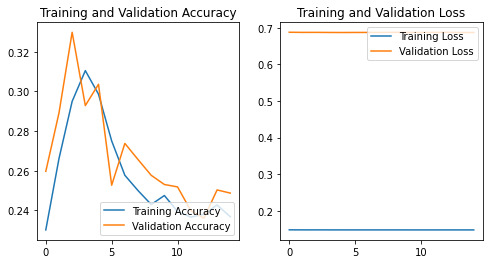

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load saved model with 10 labels

In [201]:
model = create_model()
model.load_weights('training_2/cp-0015.ckpt')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_18 (Flatten)         (None, 5120)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               655488    
_________________________________________________________________
dense_37 (Dense)             (None, 10)                1290      
Total params: 4,706,349
Trainable params: 656,778
Non-trainable params: 4,049,571
_________________________________________________________________


In [177]:
vg = datagen.flow_from_dataframe(
        dataframe=training_set_x_labels, 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size,
        shuffle=False
        )

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 39569 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 27675 validated image filenames belonging to 10 classes.


In [178]:
val_predictions = model.predict(vg)
val_predictions

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.3912923e-33, 4.0940875e-34, 0.0000000e+00, ..., 0.0000000e+00,
        2.9800855e-25, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [200]:
from collections import Counter

total = Counter()
correct = Counter()
for i in range(len(vg.classes)):
    true_y = vg.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(val_predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], correct[k]/total[k]))

Media* 0/2807 == 0.0
Music 0/1230 == 0.0
Sports 1111/3607 == 0.308012198502911
Visual arts* 0/6626 == 0.0
Geographical 0/4484 == 0.0
Military and warfare 0/3721 == 0.0
Society 0/1687 == 0.0
Biology 2111/4021 == 0.524993782641134
STEM* 3299/8453 == 0.390275641783982
Space 0/515 == 0.0


In [180]:
name_id_map

{'Culture.Media.Media*': 0,
 'Culture.Media.Music': 1,
 'Culture.Sports': 2,
 'Culture.Visual arts.Visual arts*': 3,
 'Geography.Geographical': 4,
 'History and Society.Military and warfare': 5,
 'History and Society.Society': 6,
 'STEM.Biology': 7,
 'STEM.STEM*': 8,
 'STEM.Space': 9}

In [181]:
def get_y_true(classes, preset_nr_classes=0):
    """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
    nr_images = len(classes)
    if not preset_nr_classes:
        nr_classes = len(set([item for sublist in classes for item in sublist]))
    else:
        nr_classes = preset_nr_classes
    y_true = np.zeros((nr_images, nr_classes))
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Average precision scores (macro):
0.21142846007152483

 ROC AUC score:
0.5650793642485303


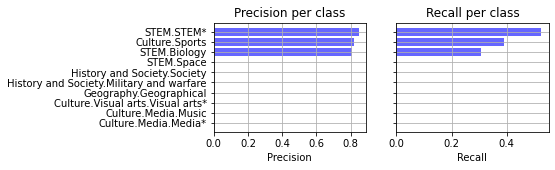

In [186]:
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

threshold = 0.5

y_pred = 1 * (val_predictions > threshold)

y_true = get_y_true(vg.classes)

n_classes = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(vg.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=n_classes), [None, None, None, None]))

# Output macro and micro accuracies
# with open(f'{self.results_path}/per_class_metrics', 'w') as f:
#     metrics_df.to_string(f)
# print(metrics_df.tail(4))

# Average precision score
# The average_precision_score function computes the average precision (AP) from prediction scores. The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction of positive samples.
print('\nAverage precision scores (macro):')
print(average_precision_score(y_true, y_pred, average='macro'))
# print(average_precision_score(y_true, y_pred, average='weighted'))

# ROC AUC score
print('\n ROC AUC score:')
print(roc_auc_score(y_true, val_predictions))

# Precision and recall for each class
fig, axs = plt.subplots(1, 2, figsize=(6,2))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:n_classes])
sorted_precisions_per_class = metrics_df.precision[0:n_classes][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:n_classes])
sorted_recalls_per_class = metrics_df.recall[0:n_classes][sorted_indices_recall]
# Plot!
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(n_classes))
axs[0].set_yticklabels(np.array(list(vg.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)
axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(n_classes))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)
plt.savefig(f'precision_recall.png')

#### Visualize images from these labels

<ipython-input-185-be55bc3b022b>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)


UnicodeEncodeError: 'latin-1' codec can't encode character '\u0117' in position 49: ordinal not in range(256)

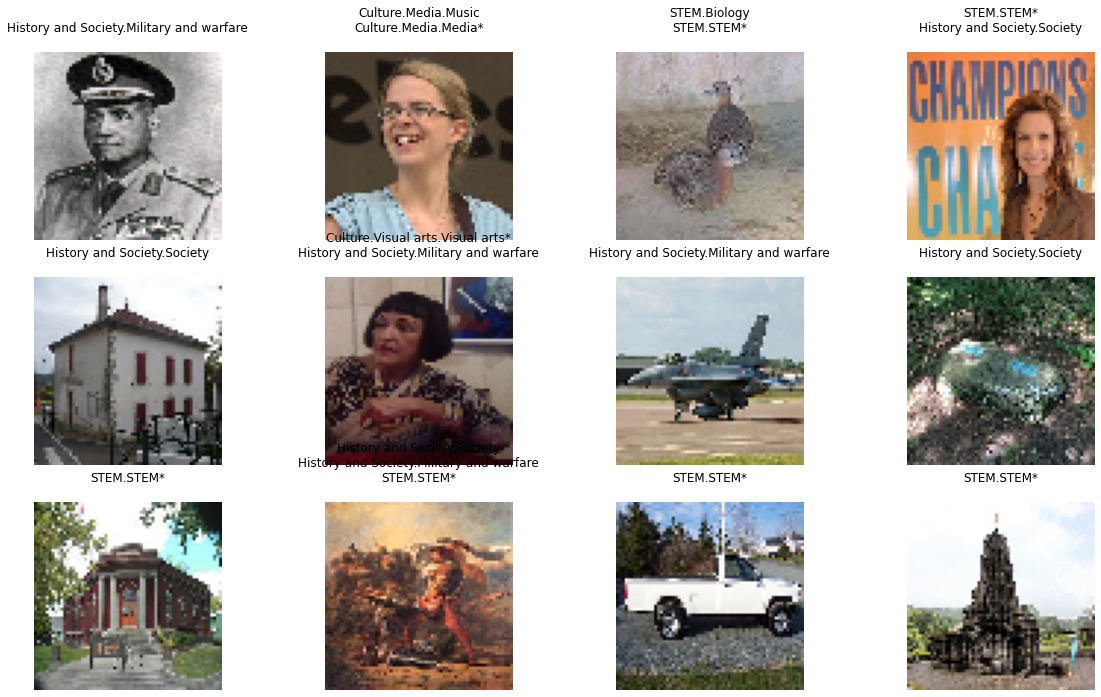

In [185]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(20, 20))
IMAGE_DIMENSION = 64
columns = 4
rows = 4
random_indices = np.random.randint(low=0, high=1e5, size=(rows,columns))
for i, idx in enumerate(random_indices.flatten()):
    path = '/scratch/WIT_Dataset/images/' + training_set_x_labels.iloc[idx, :].image_path
    img = load_img(path, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
    plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = ''.join([label + '\n' for label in training_set_x_labels.iloc[idx, :].labels])
    plt.title(title)
plt.suptitle('Some images and their ground truths')